<center> <h1> Variational Autoencoder using Pytorch </h1> </center>

## Introduction

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from image_utils import load_images_from_path
from torchvision import datasets, transforms
from torchsummary import summary
import torchvision

In [2]:
input_shape = (190,105)

## 1. Sampling

We implement the sampling class in order to use the reparameterization trick. In fact, this trick is used in VAEs to sample from the posterior distribution of the latent space variables (z) given the inputs (z_mean, z_log_var) while keeping the sampling process differentiable, enabling backpropagation and gradient-based optimization.

The principle is to transform the random samples from a standard normal distribution $ \sim \mathcal{N}(0,\,1)$ using the following equation:
        
Reparameterization Trick:

$$ z = z_{\text{mean}} + \exp\left(\frac{1}{2} z_{\text{log\_var}}\right) \cdot \epsilon $$

where $ \epsilon $ is a random sample from the standard normal distribution $\sim \mathcal{N}(0,\,1)$.

In [3]:
class Sampling(nn.Module):
    """
    Implementation of the reparameterization trick (to make the sampling process differentiable) used in VAEs to sample from the
    posterior distribution of the latent space variables (z) given the inputs (z_mean, z_log_var).

    Parameters:
        inputs (tuple): A tuple containing two tensors : z_mean and z_log_var.

    Returns:
        torch.Tensor: A tensor containing the reparameterized latent variables z.
                      The shape of the output tensor is the same as z_mean and z_log_var.
    """

    def forward(self, inputs):
        z_mean, z_log_var = inputs
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        # generates random samples from a standard normal distribution 
        epsilon = torch.randn(batch, dim, device=z_mean.device)
        #The reparameterization trick
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon 

## 2. Encoder

The encoder is a neural network used to map input images of the crops to a triplet (z_mean, z_log_var, z) in the context of a Variational Autoencoder (VAE) architecture. 

I've adjusted the size of the self.dense layer to accommodate the input shape different input shapes instead of using a fixed one (in the Keras implementation)


In [4]:
class Encoder(nn.Module):
    """Maps crops to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, n_rows=64 ,n_cols=64 ,n_channels=1, conv_dim1 = 32, conv_dim2 = 64, h_dim = 128, latent_dim=32):
        super(Encoder, self).__init__()
        
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.latent_dim = latent_dim
    
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=conv_dim1, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=conv_dim1, out_channels=conv_dim2, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(conv_dim2 * (self.n_rows//4) * (self.n_cols//4), h_dim)
        self.dense_mean = nn.Linear(h_dim, self.latent_dim)
        self.dense_log_var = nn.Linear(h_dim, self.latent_dim)
        self.sampling = Sampling()

    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.dense(x))
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

## 3. Decoder

In [5]:
class Decoder(nn.Module):
    """Maps latent variables (z) back to the original image space."""

    def __init__(self, latent_dim=32, n_rows=64, n_cols=64, n_channels=1, conv_dim1=32, conv_dim2=64, h_dim=128):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.n_pixels = n_rows * n_cols
        self.h_dim = h_dim
        self.conv_dim2 = conv_dim2

        # The initial hidden layer size after flattening the latent variables
        new_n_rows , new_n_cols = (self.n_rows)//4 , (self.n_cols)//4   
        self.initial_layer_size = conv_dim2 * new_n_rows * new_n_cols
        self.new_n_rows = new_n_rows
        self.new_n_cols = new_n_cols
        # Decoder layers
        self.dense = nn.Linear(self.latent_dim, self.h_dim)
        self.dense_to_conv = nn.Linear(self.h_dim, self.initial_layer_size)
        self.deconv0 = nn.ConvTranspose2d(in_channels=conv_dim2, out_channels=conv_dim2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(in_channels=conv_dim2, out_channels=conv_dim1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=conv_dim1, out_channels=n_channels, kernel_size=3, padding=1)

    def forward(self, z):
        x = F.relu(self.dense(z))
        x = F.relu(self.dense_to_conv(x))
        x = x.view(-1, self.conv_dim2, self.new_n_rows, self.new_n_cols)
        x = F.relu(self.deconv0(x))
        x = F.relu(self.deconv1(x))
        x = F.sigmoid(self.deconv2(x))
        return x


## 4. The VAE


In [16]:
class BetaVAE(nn.Module):

    def __init__(self, beta=1.0, n_rows=64, n_cols=64, n_channels=1, conv_dim1=32, conv_dim2=64, h_dim=128, latent_dim=32):
        super(BetaVAE, self).__init__()

        self.encoder = Encoder(n_rows=n_rows, n_cols=n_cols, n_channels=n_channels, conv_dim1=conv_dim1, conv_dim2=conv_dim2, h_dim=h_dim, latent_dim=latent_dim)
        self.sampling = Sampling()
        self.decoder = Decoder(latent_dim=latent_dim, n_rows=n_rows, n_cols=n_cols, n_channels=n_channels, conv_dim1=conv_dim1, conv_dim2=conv_dim2, h_dim=h_dim)
        self.beta = beta

    def forward(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed_image = self.decoder(z)
        #print(reconstructed_image.shape)
        return reconstructed_image,z_mean,z_log_var

    def loss_function(self, reconstructed, original, z_mean, z_log_var):

        # Reconstruction loss (pixel-wise mean squared error)
        reconstruction_loss = F.mse_loss(reconstructed, original, reduction='sum')

        # KL-divergence loss
        kl_divergence_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

        # Total loss
        total_loss = reconstruction_loss + self.beta * kl_divergence_loss

        return total_loss, reconstruction_loss, kl_divergence_loss

In [17]:
def train_VAE(crops, n_rows=64, n_cols=64, latent_dim=8, beta=1, epochs=20, batch_size=32,
                  learning_rate=1e-3, validation_split=0.2, plot_history=True,
                  save_model=True, saving_path='./newmodel'):


    def __plot_history(history):
        plt.figure(figsize=(10, 5))
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        model_name = "modelMNIST_zdim_" + str(latent_dim)+"_beta_"+ str(beta)+"_epochs_"+str(epochs)
        plt.savefig('./models_MNIST/loss_'+model_name+'.png')
        plt.show()

    # Convert the crops to a PyTorch tensor
    crops = torch.tensor(crops)

    # Create an instance of the BetaVAE model
    vae = BetaVAE(beta=beta, latent_dim=latent_dim, n_cols=28, n_rows=28)
    #summary(vae)
    # Define the optimizer
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

    # Lists to store loss history for plotting
    train_loss_history = []
    val_loss_history = []

    # Split the data into training and validation sets
    split_idx = int((1 - validation_split) * len(crops))
    train_data = crops[:split_idx]
    val_data = crops[split_idx:]

    # Training loop
    for epoch in range(epochs):
        vae.train()
        total_train_loss = 0

        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size]
            optimizer.zero_grad()
            reconstructed,z_mean,z_log_var = vae(batch)
            loss, reconstruction_loss, kl_divergence_loss = vae.loss_function(
                reconstructed, batch, z_mean, z_log_var
            )
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_data)
        train_loss_history.append(avg_train_loss)

        # Validation
        vae.eval()
        with torch.no_grad():
            total_val_loss = 0

            for i in range(0, len(val_data), batch_size):
                batch = val_data[i:i+batch_size]
                reconstructed, z_mean, z_log_var = vae(batch)
                loss, _, _ = vae.loss_function(reconstructed, batch, z_mean, z_log_var)
                total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_data)
            val_loss_history.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if plot_history:
        history = {'loss': train_loss_history, 'val_loss': val_loss_history}
        __plot_history(history)

    if save_model:
        torch.save(vae.state_dict(), saving_path)

    return vae

In [18]:
# def get_mnist_data(data_dir='./data'):
#     transform = transforms.Compose([
#         transforms.ToTensor()
#     ])

#     train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)

#     # Concatenate all images to form crops (flattened images)
#     crops = torch.cat([img.unsqueeze(1) for img, _ in train_dataset], dim=0)
#     labels = torch.tensor([label for _, label in train_dataset])
#     return crops,labels


In [19]:

# data_path = '../segmentation/data_for_VAE/220429_ MCF10A  laminAC fibro phallo pattern mars 2022\*.PNG'
# _,crops = load_images_from_path(data_path)
# crops = np.expand_dims(crops, axis=1).astype("float32") / 255
# crops[0].shape

### MNIST dataset

In [20]:

# Define a transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders to handle batch processing
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([60000, 1, 28, 28])
Y_train shape: torch.Size([60000])
X_test shape: torch.Size([10000, 1, 28, 28])
Y_test shape: torch.Size([10000])


### Train a model with latent_dim = 16

In [23]:
batch_size = 64  # You can adjust this based on your hardware and memory limitations
latent_dim = 16
beta = 1
epochs = 15
n_rows = 28
n_cols = 28
model_name = "modelMNISTCONV_zdim_" + str(latent_dim)+"_beta_"+ str(beta)+"_epochs_"+str(epochs)
crops = X_train

C:\Users\souhm\AppData\Local\Temp\ipykernel_17344\328063230.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  crops = torch.tensor(crops)


Epoch [1/15] - Train Loss: 48.7833 - Val Loss: 42.4875
Epoch [2/15] - Train Loss: 40.9827 - Val Loss: 40.2844
Epoch [3/15] - Train Loss: 39.9357 - Val Loss: 39.6492
Epoch [4/15] - Train Loss: 39.5544 - Val Loss: 39.8223
Epoch [5/15] - Train Loss: 39.3766 - Val Loss: 39.4874
Epoch [6/15] - Train Loss: 39.2429 - Val Loss: 39.2207
Epoch [7/15] - Train Loss: 39.0943 - Val Loss: 39.2687
Epoch [8/15] - Train Loss: 38.9432 - Val Loss: 38.7149
Epoch [9/15] - Train Loss: 38.8463 - Val Loss: 38.5265
Epoch [10/15] - Train Loss: 38.7030 - Val Loss: 38.5387
Epoch [11/15] - Train Loss: 38.6187 - Val Loss: 38.3728
Epoch [12/15] - Train Loss: 38.5729 - Val Loss: 38.4480
Epoch [13/15] - Train Loss: 38.5511 - Val Loss: 38.3030
Epoch [14/15] - Train Loss: 38.4802 - Val Loss: 38.3256
Epoch [15/15] - Train Loss: 38.5086 - Val Loss: 38.3626


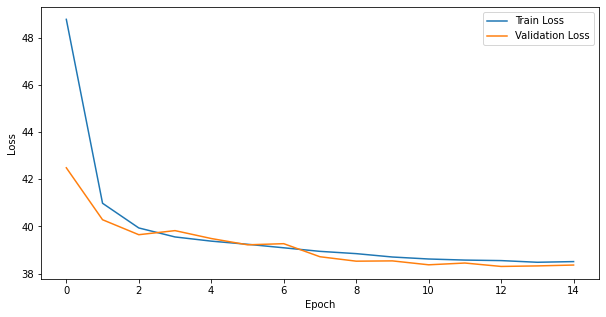

In [25]:
vae = train_VAE(crops=crops, n_rows=28, n_cols=28, latent_dim=latent_dim, beta=beta, epochs=epochs,                 batch_size=64, learning_rate=0.01, validation_split=0.2,
                plot_history=True, save_model=True, saving_path='./models_MNIST/'+model_name+'.pth')

In [26]:
model = BetaVAE(beta=1, latent_dim=16,n_rows=28,n_cols=28)
model.load_state_dict(torch.load('./models_MNIST/modelMNISTCONV_zdim_16_beta_1_epochs_15.pth'))
model.eval()

BetaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=3136, out_features=128, bias=True)
    (dense_mean): Linear(in_features=128, out_features=16, bias=True)
    (dense_log_var): Linear(in_features=128, out_features=16, bias=True)
    (sampling): Sampling()
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (dense): Linear(in_features=16, out_features=128, bias=True)
    (dense_to_conv): Linear(in_features=128, out_features=3136, bias=True)
    (deconv0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

### Clustering using GaussianMixture

In [27]:
from umap import UMAP
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

#z_mean, z_log_var, z_train = model.encoder(X_test)
_, _, z_test = model.encoder(X_test)
n_clusters = 10
z_test = z_test.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(z_test)

c:\Users\souhm\anaconda3\envs\allwhatyouneed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
cmap = plt.cm.get_cmap('viridis', 10)
cmap2 = cmap.reversed()

<Figure size 432x288 with 0 Axes>

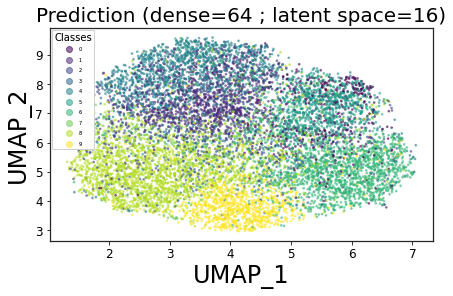

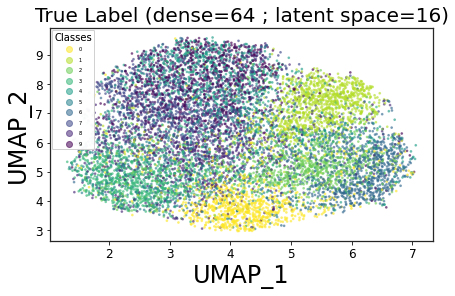

In [66]:
# 2D representation latent space n>2 matplotlib

umap_2d = UMAP(n_components=2, init='random', random_state=0) 
#tsne = Isomap(n_components=2)
#tsne = SpectralEmbedding(n_components=2)
#tsne = LocallyLinearEmbedding(n_components=2)
proj_2d = umap_2d.fit_transform(z_test)  
params = {'backend': 'Agg',
          "font.family": "calibri",
              } # extend as needed
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
fig = plt.figure()

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

fig, ax=plt.subplots(layout="constrained")

scatter =ax.scatter(x=proj_2d[:,0], y=proj_2d[:,1], s=3, c=clustering_labels, alpha=0.5, cmap=cmap)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes",fontsize = 5)

ax.set_facecolor("white")
ax.add_artist(legend1)

#image_format = 'svg' # e.g .png, .svg, etc.
#image_name = 'C:/Users/betti/Desktop/Resultats/Article VAE/saved_model/FASHION MNIST/beta=1, epoch =20, batch=32_v2/figures/latent space =32/myimage.svg'
plt.title('Prediction (dense=64 ; latent space=16)',fontsize = 20)
plt.xlabel('UMAP_1', fontsize = 24)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('UMAP_2',fontsize = 24)
# path=r'C:\Users\betti\Desktop\Resultats\Article VAE\figure_v2\MNIST\latent64_dense64_pred.png'
# plt.savefig(path, dpi=1200)

plt.show()

fig, ax=plt.subplots(layout="constrained")


scatter =ax.scatter(x=proj_2d[:,0], y=proj_2d[:,1], s=3, c=y_test, alpha=0.5, cmap=cmap2)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes", fontsize = 5)

ax.set_facecolor("white")
ax.add_artist(legend1)

#image_format = 'svg' # e.g .png, .svg, etc.
#image_name = 'C:/Users/betti/Desktop/Resultats/Article VAE/saved_model/FASHION MNIST/beta=1, epoch =20, batch=32_v2/figures/latent space =32/true_lab.svg'
plt.title('True Label (dense=64 ; latent space=16)',fontsize = 20)
plt.xlabel('UMAP_1', fontsize = 24)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('UMAP_2',fontsize = 24)
# path=r'C:\Users\betti\Desktop\Resultats\Article VAE\figure_v2\MNIST\latent64_dense64_true.png'
# plt.savefig(path, dpi=1200)

plt.show()

### Samples of each cluster

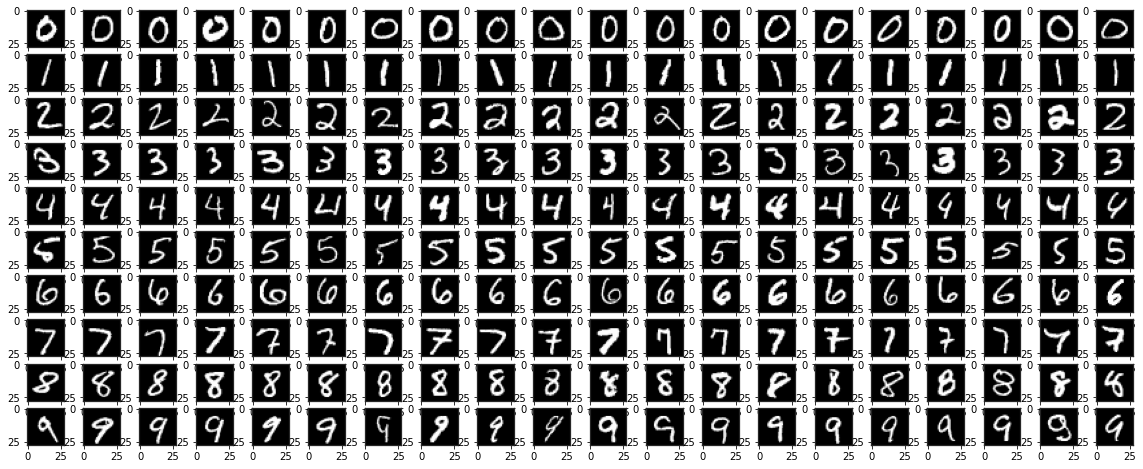

In [70]:
# Samples from each cluster
nb_samples = 20
l = list(set(y_test))

fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,8))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(y_test == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].grid(False)
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

In [ ]:
# # 2D representation latent space n=2 (matplotlib)
# import numpy as np
# import matplotlib.pyplot as plt

# # Fixing random state for reproducibility

# x = z_test[:,0]
# y = z_test[:,1]

# params = {'backend': 'Agg',
#           "font.family": "calibri",
#               } # extend as needed
# plt.rcParams["axes.edgecolor"] = "0.15"
# plt.rcParams["axes.linewidth"]  = 1.25
# fig = plt.figure()

# plt.rcParams["axes.edgecolor"] = "0.15"
# plt.rcParams["axes.linewidth"]  = 1.25

# #fig, ax = plt.subplots()
# fig, ax=plt.subplots(layout="constrained")

# scatter =ax.scatter(x, y, s=3, c=clustering_labels, alpha=0.5, cmap='viridis')
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes", fontsize = 5)

# ax.set_facecolor("white")
# ax.add_artist(legend1)

# #image_format = 'svg' # e.g .png, .svg, etc.
# plt.title('Prediction ( latent space=32)',fontsize = 20)
# plt.xlabel('Dim_1', fontsize = 24)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.ylabel('Dim_2',fontsize = 24)
# #fig.savefig(image_name, format=image_format, dpi=1200)

# plt.show()

# fig, ax=plt.subplots(layout="constrained")

# scatter =ax.scatter(x, y, s=3, c=y_test, alpha=0.5, cmap='viridis')
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes", fontsize = 5)

# ax.set_facecolor("white")
# ax.add_artist(legend1)

# #image_format = 'svg' # e.g .png, .svg, etc.
# #image_name = 'C:\Users\betti\Desktop\Resultats\Article VAE\saved_model\MNIST\figures\beta=1, epoch =20, batch=32_v2\latent space =2\true_lab.svg'
# plt.title('True Label (dense layer=64 ; latent space=32)',fontsize = 20)
# plt.xlabel('Dim_1', fontsize = 24)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.ylabel('Dim_2',fontsize = 24)

# # plt.show()